## Carregando as frases e as palavras:

In [1]:
teste = [
         'Comprar uma camisa que cubra meus braços para usar nos tempos de frio',
         'Uma barragem, açude ou represa é uma barreira artificial, feita em cursos de água para a retenção de grandes quantidades de água. A sua utilização é sobretudo para o abastecimento de água de zonas residenciais, agrícolas, industriais, produção de energia elétrica, ou regularização de um caudal.',
         'pesquisador alerta para o consumo de peixes e banho na lagoa da conceição',
         'Corpo do homem que desapareceu em lagoa é encontrado pelos Bombeiros',
         'Manga é a parte de uma roupa que cobre o braço, por parte ou por completo.',
         'As mangas variaram muito em estilo de acordo com a época e com a cultura, e de acordo com a função social do trabalhador.',
         'Raisa limpou o rosto com a manga da túnica.',
         'Sem dizer nada, ela puxou a manga e estendeu o braço.',
         'Uma lagoa pode ter uma população pequena de rãs; um prado, uma população pequena de roedores.',
         'Atravessou correndo o bosque sagrado, escolhendo o caminho mais longo, a fim de evitar a lagoa onde crescia a árvore-coração.',
         'Daquela distância, a lagoa das salamandras, que ficava atrás do palácio, tinha a dimensão de uma poça de água qualquer.',
         'O jardim descia até um açude e, dos lados, bosques espessos abrigavam-me dos olhares; à minha volta, grandes esquilos cinzentos corriam, e pássaros cantavam.',
         'Por volta do meio-dia, atravessávamos o açude de barco; escalávamos e descíamos as dunas que nos queimavam os pés; chegávamos à beira do lago Michigan, grande e agitado como o mar: ninguém na praia arenosa e infinita, onde ciscavam aves brancas, empoleiradas em suas patas.'
    
        ]
palavra = [
        'manga',
        'açude',
        'lagôa',
        'lagôa',
        'manga',
        'manga',
        'manga',
        'manga',
        'lagôa',
        'lagôa',
        'lagôa',
        'açude',
        'açude'
        ]

## Importando as biblioteacas e o dicionáio:

In [2]:
import pandas as pd
from xml.etree import ElementTree as ET
import os
import glob
import nltk
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

stopwordsnltk = nltk.corpus.stopwords.words('portuguese')
stemmer = nltk.stem.RSLPStemmer()

dados = []
gramatica = []
i = 0

path = os.getcwd() + '/dicionarioXML'

temp = [
    "gambá",
    "açude",
    "lagôa",
    "ponte",
    "passarela",
    "manga"]
temp2 = sorted(temp)
aux2 = ''

for temp3 in temp2:
    temp3 = temp3.upper()
    
    if(aux2 != temp3[0]):
        allFiles = glob.glob(path+'/'+temp3[0]+'.xml')
        #allFiles = glob.glob(path+'/*.xml')
    
        # Saving the dictionary
        for fil in allFiles:
            print('Processando arquivo:', fil[-5:])
            root = ET.parse(fil).getroot()
            for word in root.findall('entry'):
                gotWord  = False
                gotOrth  = False
                gotGram  = False

                try:
                    iD = word.get('id')
                    gotWord = True
                except AttributeError:
                    pass
                try:    
                    orth = word.find('form/orth').text
                    gotOrth = True
                except AttributeError:
                    pass
                try:
                    temp = []
                    j = 0
                    temp.append([])
                    for senti in word:
                        for grama in senti.findall('gramGrp'):
                            temp[j].append(grama.text)

                        for sen in senti.findall('def'):
                            defi = sen.text
                            defi = defi.replace('\n' ,'')
                            defi = defi.replace('_' ,'')
                            temp[j].append(defi)

                        if temp[j] != []:
                            j += 1
                            temp.append([])

                    if len(temp) != 0:
                        if temp[-1] == []:
                            del temp[-1]
                        gramatica.append([])
                        gramatica[i] = temp
                    gotGram = True
                except AttributeError:
                    pass
                if gotGram and gotOrth and gotWord:
                    dados.append([])
                    dados[i] = [iD, orth.lower(), gramatica[i]]
                    i += 1
    aux2 = temp3[0]


dic = []
for word in dados:
    emp = word[2]
    for aux in emp:
        emp2 = ()
        emp2 = (word[1], aux[-1])
        dic.append(emp2)

/home/matheus/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


Processando arquivo: A.xml
Processando arquivo: G.xml
Processando arquivo: L.xml
Processando arquivo: M.xml
Processando arquivo: P.xml


## Aplicação do pre-processamento dos textos

In [3]:
defns = []

def fazstemmer(texto):    
    frasessstemming = []
    for (palavras, sentido) in texto:
        for temp in temp2:
            if not (not palavras) and palavras == temp:
                predef = [str(stemmer.stem(p))
                         for p in sentido.split() if p not in stopwordsnltk]
                defns.append((palavras ,sentido))
                frasessstemming.append((predef, sentido))
                
    return frasessstemming

frasescomstemming = fazstemmer(dic)

if not frasescomstemming:
    print('=====palavra não encontrada======')
else:
    def buscapalavras(frases):
        todaspalavras = []
        for (palavras, sentido) in frases:
            todaspalavras.extend(palavras)
        return todaspalavras


    palavras = buscapalavras(frasescomstemming)
    
    def buscafrequencia(palavras):
        palavras = nltk.FreqDist(palavras)
        return palavras
    
    
    frequenciatreinamento = buscafrequencia(palavras)
    
    def busca_palavrasunicas(frequencia):
        freq = frequencia.keys()
        return freq


    palavrasunicas = busca_palavrasunicas(frequenciatreinamento)

    def extraipalavras(documento):
        doc = set(documento)
        caracteristicas = {}
        for palavras in palavrasunicas:
            caracteristicas['%s' % palavras] = (palavras in doc)
        return caracteristicas

    
    basecompleta = nltk.classify.apply_features(extraipalavras, frasescomstemming)
    
    classificador = nltk.NaiveBayesClassifier.train(basecompleta)
    
    def extrai_palavras(documento):
        doc = set(documento)
        caracteristicas = {}
        for palavras in palavrasunicas:
            caracteristicas['%s' % palavras] = (palavras in doc)
        return caracteristicas

esperado = []

Agora passaremos para o nosso algorítimo as frases que declaramos no início, dessa forma, ele nos retornara a palavra e o significado jundo com a pontuação que vai de 0 a 1 para cada provável definição de cada uma das palavras em suas respectivas frases.

In [4]:
classes = []
score = []
def ia(teste, palavra):
    testestem = []

    for (palavrastreinamento) in teste.split():
        comstem = [p for p in palavrastreinamento.split()]
        testestem.append(str(stemmer.stem(comstem[0])))

    nova_frase = extrai_palavras(testestem)

    distribuicao = classificador.prob_classify(nova_frase)

    print('-----------------------')
    i = 0
    count = 0
    classes = []
    score = []

    for classe in distribuicao.samples():
        if (distribuicao.prob(classe)*100) >= 1 and defns[i][0] == palavra:    
            #print("%s: %f" % (classe, (distribuicao.prob(classe))))
            classes.append(classe)
            score.append(distribuicao.prob(classe))
            if distribuicao.prob(classe)*100 == count:
                temps = classe
                result.append(temps)
            elif distribuicao.prob(classe)*100 > count:
                count = distribuicao.prob(classe)*100
                result = [(defns[i][0],classe)]
        i+=1 
    d = {'Classe': classes, 'Score': score}
    df = pd.DataFrame(data=d)
    print(df.sort_values(by='Score', ascending=False))
    print("\nO somatorio das probabilidades he: " + str(round(df['Score'].sum(),2)))

    #print("Resposta: ")
    for definition in result:
        #print(definition)
        if definition[0] == palavra:
            result = definition[1]
            #print(result)

    #print(result)
    esperado.append(result)

for i in teste:
    ia(teste[teste.index(i)],palavra[teste.index(i)])
    
#print(esperado)


-----------------------
                                         Classe     Score
0  Parte do vestuário, com que se cobre o braço  0.120149
1                                Tromba de água  0.120149
2                          Chaminé de candeeiro  0.120149
6              Ramal da estrada de seringueiras  0.040050
7     Prolongamento de uma herdade entre outras  0.040050
3                        Chocalho grande, choca  0.040050
4                         Turba, grupo de gente  0.040050
5         Fruto da mangueiraA mangueira, planta  0.013350

O somatorio das probabilidades he: 0.53
-----------------------
                      Classe     Score
0  Batoréu, arrêto(Ár. azud)  0.013696

O somatorio das probabilidades he: 0.01
-----------------------
               Classe    Score
0  Pequeno lagoCharco  0.06473

O somatorio das probabilidades he: 0.06
-----------------------
                                  Classe     Score
0                     Pequeno lagoCharco  0.134515
1  Belga grande, 

## Matriz Confusão:

In [5]:
from nltk.metrics import ConfusionMatrix

previsto = [
    'Parte do vestuário, com que se cobre o braço',
    'Batoréu, arrêto(Ár. azud)',
    'Pequeno lagoCharco',
    'Pequeno lagoCharco',
    'Parte do vestuário, com que se cobre o braço',
    'Parte do vestuário, com que se cobre o braço',
    'Parte do vestuário, com que se cobre o braço',
    'Parte do vestuário, com que se cobre o braço',
    'Pequeno lagoCharco',
    'Pequeno lagoCharco',
    'Pequeno lagoCharco',
    'Batoréu, arrêto(Ár. azud)',
    'Batoréu, arrêto(Ár. azud)',
]

matriz = ConfusionMatrix(esperado, previsto)
print(matriz)

                                             |   P     |
                                             |   a     |
                                             |   r     |
                                             |   t     |
                                             |   e     |
                                             |         |
                                             |   d     |
                                             |   o     |
                                             |         |
                                             |   v     |
                                             |   e     |
                                             |   s     |
                                             |   t     |
                                             |   u     |
                                             |   á     |
                                             |   r     |
                                             |   i     |
                               

<AxesSubplot:>

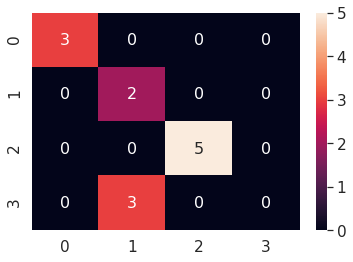

In [16]:

array = [[3,0,0,0],
         [0,2,0,0],
         [0,0,5,0],
         [0,3,0,0]]
df_cm = pd.DataFrame(array, range(4),
                  range(4))
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

## Tabela de valores sobre o classificador

A tabela aseguir nos mostra os valores referentes ao classificardor e o desempenho que ele obteve de modo geral.

In [7]:
print(classification_report(previsto, esperado))

                                              precision    recall  f1-score   support

                   Batoréu, arrêto(Ár. azud)       1.00      1.00      1.00         3
Parte do vestuário, com que se cobre o braço       1.00      0.40      0.57         5
                          Pequeno lagoCharco       1.00      1.00      1.00         5
                              Tromba de água       0.00      0.00      0.00         0

                                    accuracy                           0.77        13
                                   macro avg       0.75      0.60      0.64        13
                                weighted avg       1.00      0.77      0.84        13



/home/matheus/snap/jupyter/common/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
